## Preamble

For this notebook you will need

+ numpy
+ matplotlib
+ scipy
+ scikit-learn
+ [dysts](https://github.com/williamgilpin/dysts)

$$
% \let\vaccent=\v % rename builtin command \mathbf{} to \vaccent{}
% \renewcommand{\v}[1]{{\mathbf{#1}}} % for vectors
% \renewcommand{\gv}[1]{{\mbox{\boldmath$ #1 $}}} 
% \renewcommand{\uv}[1]{{\mathbf{\hat{#1}}}} % for unit vector
% \renewcommand{\abs}[1]{\left| #1 \right|} % for absolute value
% \renewcommand{\avg}[1]{\left< #1 \right>} % for average
% % \let\underdot=\d % rename builtin command \d{} to \underdot{}
% \newcommand{\d}[2]{\frac{d #1}{d #2}} % for derivatives
% \newcommand{\dd}[2]{\frac{d^2 #1}{d #2^2}} % for double derivatives
% \newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}} 
% \renewcommand\eqref[1]{Eq.\;\ref{#1}} % new version of eqref
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Use autoreload to reload modules when they are changed
%load_ext autoreload
%autoreload 2


# Principal Component Analysis and Unsupervised Learning

When working with high-dimensional data, it can be helpful to reduce the effective dimensionality of the data by reducing the number of features. For example, suppose we are synthesizing a crystalline material via epitaxy. After preparing a sample, we can measure several properties: reflectivity, conductance, brittleness, etc. After creating a bunch of samples, and measuring several properties for each sample, we want to analyze the relationship among the different features/properties in a systematic way.

If we denote a given experiment $i$ with the measurement vector $\mathbf{x}_i \in \mathbb{R}^{N_{feats}}$, then we can represent all of our experiments in a *design matrix* $X \in \mathbb{R}^{N_{data} \times N_{feats}}$, where $N_{data}$ denotes the number of samples or experiments, and $N_{feats}$ represents the number of measurements or features we record for each sample.

We know that several of our features are highly correlated across our experiments. Can we find a lower-dimensional representation of our dataset $X' \in \mathbb{R}^{N_{data} \times k}$, $k < N_{feats}$, that describes the majority of variation in our dataset?

In principle, reducing the dimensionality of a dataset requires finding an injective function that maps each set of measured features to some lower dimensional set of features,
$$
\mathbf{x}' = \mathbf{f}(\mathbf{x})
$$

If this function is linear in the features, $\mathbf{f}(\mathbf{x}) = C^T \mathbf{x}$, then this problem reduces to finding the coefficient matrix $C \in \mathbb R^{N_{feats} \times k}$. For this linear case, we can use Principal Component Analysis (PCA).

The basic idea of PCA is that the eigenvectors of a dataset's covariance matrix reveal dominant patterns within the dataset, and so by projecting the dataset onto a subset of these eigenvectors, we can find lower-dimensional representation of the data. PCA is optimal in the sense that the first $k$ principal components represent a unique $k$ dimensional representation of a dataset that captures the most variance in the original data. Because PCA is a linear transform (we project the data on a set of basis vectors), then if we project the original dataset onto the full set of $N_{feats}$ eigenvectors, we basically will have rotated our dataset in a high-dimensional vector space, without discarding any information. [More info about PCA here](http://pmaweb.caltech.edu/~physlab/lab_21_current/Ph21_5_Covariance_PCA.pdf)

Mathematically, the steps of computing PCA are relatively simple. We center our data by the feature-wise mean vector, compute the covariance matrix, compute the eigenvectors, sort them in descending order of accompanying eigenvalue magnitude, and then stack the first $k$ eigenvectors to create the coefficient matrix
$$
X = X_r - \bar{X_r}
$$
$$
\Sigma = \dfrac{1}{N_{data}} X^T X
$$

$$
\mathbf{v}_i = \text{Sort}[\text{eig}(\Sigma)]_i        
$$
$$
C = \{\mathbf{v}_1, \mathbf{v}_2, ..., \mathbf{v}_k \}
$$
where $\text{eig}$ denotes the $i^{th}$ eigenvector of $\Sigma$. The coefficient matrix $C$ denotes the first $k$ eigenvectors stacked on top of each other, sorted in *decreasing* order of the magnitude of their associated eigenvalue. In this context, we call the eigenvalues the "singular values" of the original data matrix $X$, while the eigenvectors are the principal components. The central idea of PCA is that the first $k$ principal components (sorted in descending order of eigenvalue magnitude) represent the optimal variance-preserving $k$ dimensional approximation of the original dataset.

Our choice of $k \leq N_{feats}$ will depend on the properties of the dataset. In practice, we usually plot all of the eigenvalues in descending order of magnitude, and then look for a steep dropoff in their average magnitude---this indicates low dimensionality in the underlying dataset. Deciding the value of $k$ determines whether we favor a more concise and compressed representation, or a more accurate one; and various [heuristics exist](https://arxiv.org/abs/1305.5870) for determining the right threshold. After choosing $k$, we discard the remaining eigenvectors.

What's nice about PCA is that it generalizes well even to cases where $N_{feats} \gg N_{data}$. For example, if we are working with high-resolution images, each pixel is essentially a separate feature, and so $N_{feats} = 2048 \times 2048 \sim 10^6$.

PCA falls broadly under the category of unsupervised learning, which are machine learning techniques that seek to discover structure and patterns in complex data, without external information like annotations that guide the learning process. Instead, unsupervised learning techniques find alternative representations of datasets that satisfy certain desiderata. In the case of PCA, we find a representation of the data in which the first few discovered variables capture the majority of the dataset's variance, thus compressing meaningful properties of the dataset into a lower-dimensional representation.


### The von Karman vortex street

As an example dataset, we are going to use the velocity field created as a fluid flow passes over a cylinder. At low flow speeds or high fluid viscosities, the flow parts around the cylinder and then smoothly rejoins behind it. However, as the speed or viscosity decreases, an instability appears in which the flow begins to oscillate behind the cylinder, giving rise to sets of counter-rotating vortices that break off the cylinder and pass into the wake. As speed further increases, this sequence of vortices becomes more chaotic, leading to irregular downstream structure.

The control parameter governing this transition from ordered to chaotic flow is the Reynolds number,
$$
\text{Re} = \dfrac{\rho v L}{\mu}
$$
where $\rho$ is the fluid density, $v$ is the fluid speed, $L$ is the characteristic length of the cylinder, and $\mu$ is the fluid viscosity. Because $\rho$ and $\mu$ are both material properties of the fluid, they are often combined into a single parameter, the kinematic viscosity $\nu = \mu/\rho$. For water, the kinematic viscosity under standard conditions is $\nu \approx 10^{-6} \text{m}^2/\text{s}$, and for air, $\nu \approx 10^{-5} \text{m}^2/\text{s}$. The Reynolds number is a dimensionless quantity that measures the relative importance of inertial forces to viscous forces in the system. In general, flows become more turbulent at higher Reynolds numbers, and they become more frictional at lower Reynolds numbers. For example, the flow through a jet engine can reach $Re \approx 10^8$, while pouring maple syrup has $Re \approx 10^{1}$.

In the class repository, we have included very large datasets corresponding to time series of snapshots showing the velocity field of the flow past a cylinder. We include separate datasets from several different Reynolds numbers, which show how the structure of the von Karman instability changes as the flow becomes more turbulent.


### Download high-dimensional velocity field data

In [2]:
import os # Import the os module
import numpy as np # Import the numpy module
import urllib.request # Import requests module (downloads remote files)

Re = 300 # Reynolds number, change this to 300, 600, 900, 1200

fpath = f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}.npz"
if not os.path.exists(fpath):
    print("Data file not found, downloading now.")
    print("If this fails, please download manually through your browser")

    ## Make a directory for the data file and then download to it
    os.makedirs("../resources/von_karman_street/", exist_ok=True)
    url = f'https://github.com/williamgilpin/cphy/raw/main/resources/von_karman_street/vortex_street_velocities_Re_{Re}.npz'
    urllib.request.urlretrieve(url, fpath)
else: 
    print("Found existing data file, skipping download.")
  
vfield = np.load(fpath, allow_pickle=True).astype(np.float32) # Remove allow_pickle=True, as it's not a pickle file
# print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0]
print("Vorticity field dataset has shape: {}".format(vort_field.shape))


Found existing data file, skipping download.
Vorticity field dataset has shape: (375, 127, 63)


This rank 3 tensor means that our dataset consists of 375 frames, each of which has shape 127 x 375. We next plot each frame as a 127 x 63 pixel image, and we make a video slider to see the framess at each of the 375 different times.

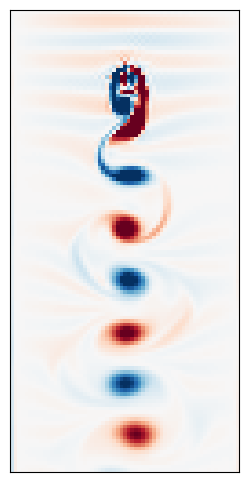

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 2**26

# Assuming frames is a numpy array with shape (num_frames, height, width)
frames = vort_field.copy()[::4]
vmax = np.percentile(np.abs(frames), 98)

fig = plt.figure(figsize=(6, 6))
img = plt.imshow(frames[0], vmin=-vmax, vmax=vmax, cmap="RdBu")
plt.xticks([]); plt.yticks([])
# tight margins
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())

def update(frame):
        img.set_array(frame)

ani = FuncAnimation(fig, update, frames=frames, interval=100)
HTML(ani.to_jshtml())

Principal components analysis takes data that is high dimensional and projects it into a lower dimensional space. Each image is has shape 127 x 63, but we can think of each image as a vector of length 127 x 63 = 8001 elements. To make this more explicit, we flatten our image stack into vectors.

In [4]:
# flatten along last two dimensions
X = vort_field.reshape(-1, vort_field.shape[1] * vort_field.shape[2])
print(X.shape)


(375, 8001)


We can now use principal components analysis to reduce the dimensionality of each of the 375 datapoints from 8001 dimensions to 20 dimensions.

/Users/william/mamba/envs/quake/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/william/mamba/envs/quake/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/william/mamba/envs/quake/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/william/mamba/envs/quake/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/william/mamba/envs/quake/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/william/mamba/envs/quake/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = no

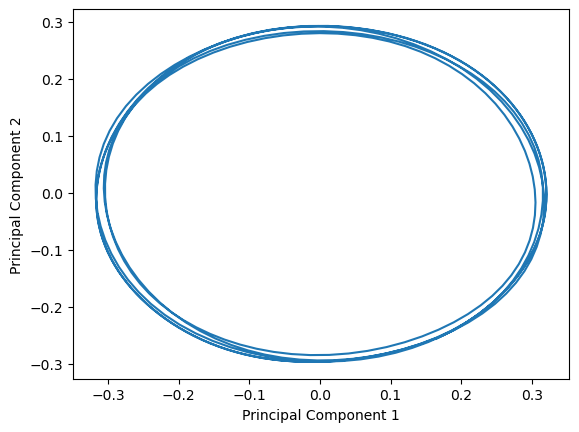

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X)

plt.plot(X_reduced[:, 0], X_reduced[:, 1], '-')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can see that, when viewed in the first two principal components, the vortex street dynamics form a limit cycle. This is consistent with the original video, which shows a periodic patterns of vortices.

We can next look at the matrix that PCA uses to map each 8001 element vector into the 20 principal components. This corresponds to a matrix of shape (8001, 20). However, in order to interpret this matrix, we need to reshape it into a 3D tensor of shape (127, 63, 20) and inspect each of the 20 components separately

(20, 8001)


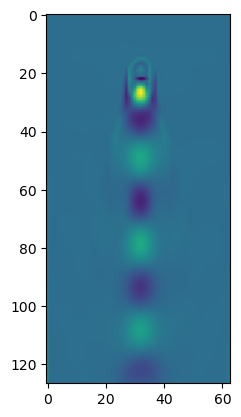

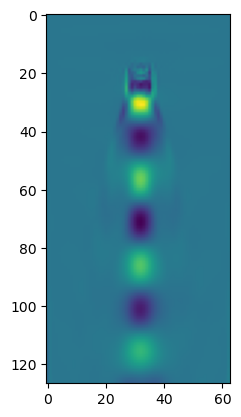

In [6]:
print(pca.components_.shape)

plt.figure()
plt.imshow(pca.components_[0].reshape(127, 63))

plt.figure()
plt.imshow(pca.components_[1].reshape(127, 63))

We can see that the principal components correspond to two opposite vortex pattern. The low-dimensional dynamics can be thought of as periodic oscillation that modulates between these two patterns, simular to how a traveling wave corresponds to a periodic oscillation between two standing waves

How many reduced order variables are needed to capture the dynamics? We know that we have up to 20 principal components, but do we need all of them?

Text(0, 0.5, 'Eigenvalue rank')

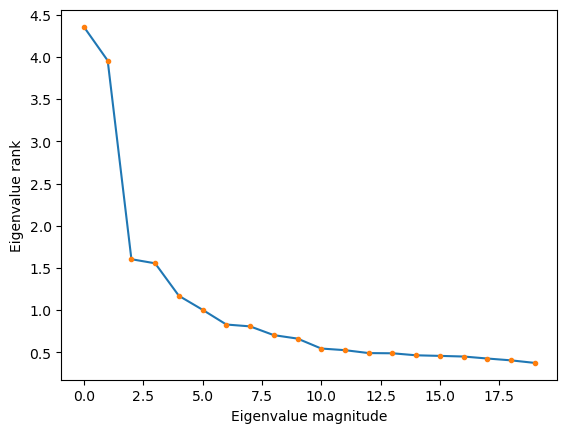

In [7]:
## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(pca.singular_values_[:50])
plt.plot(pca.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

We can see that the first 2 principal capture most of the variance in the data. This implies that the data lives in a 2-dimensional manifold, consistent with the idea that this dataset is a limit cycle.

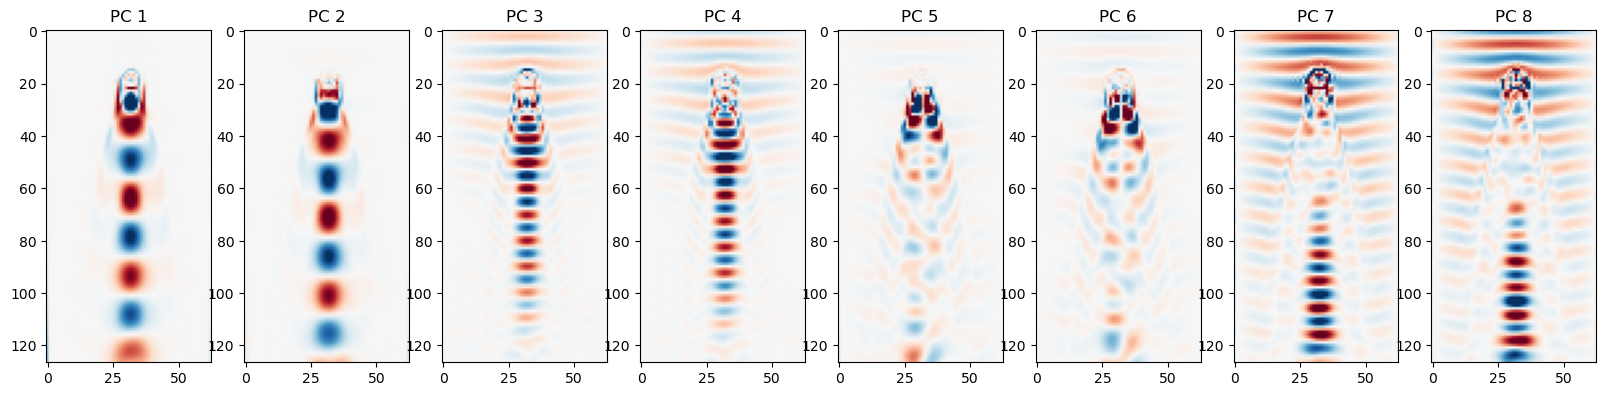

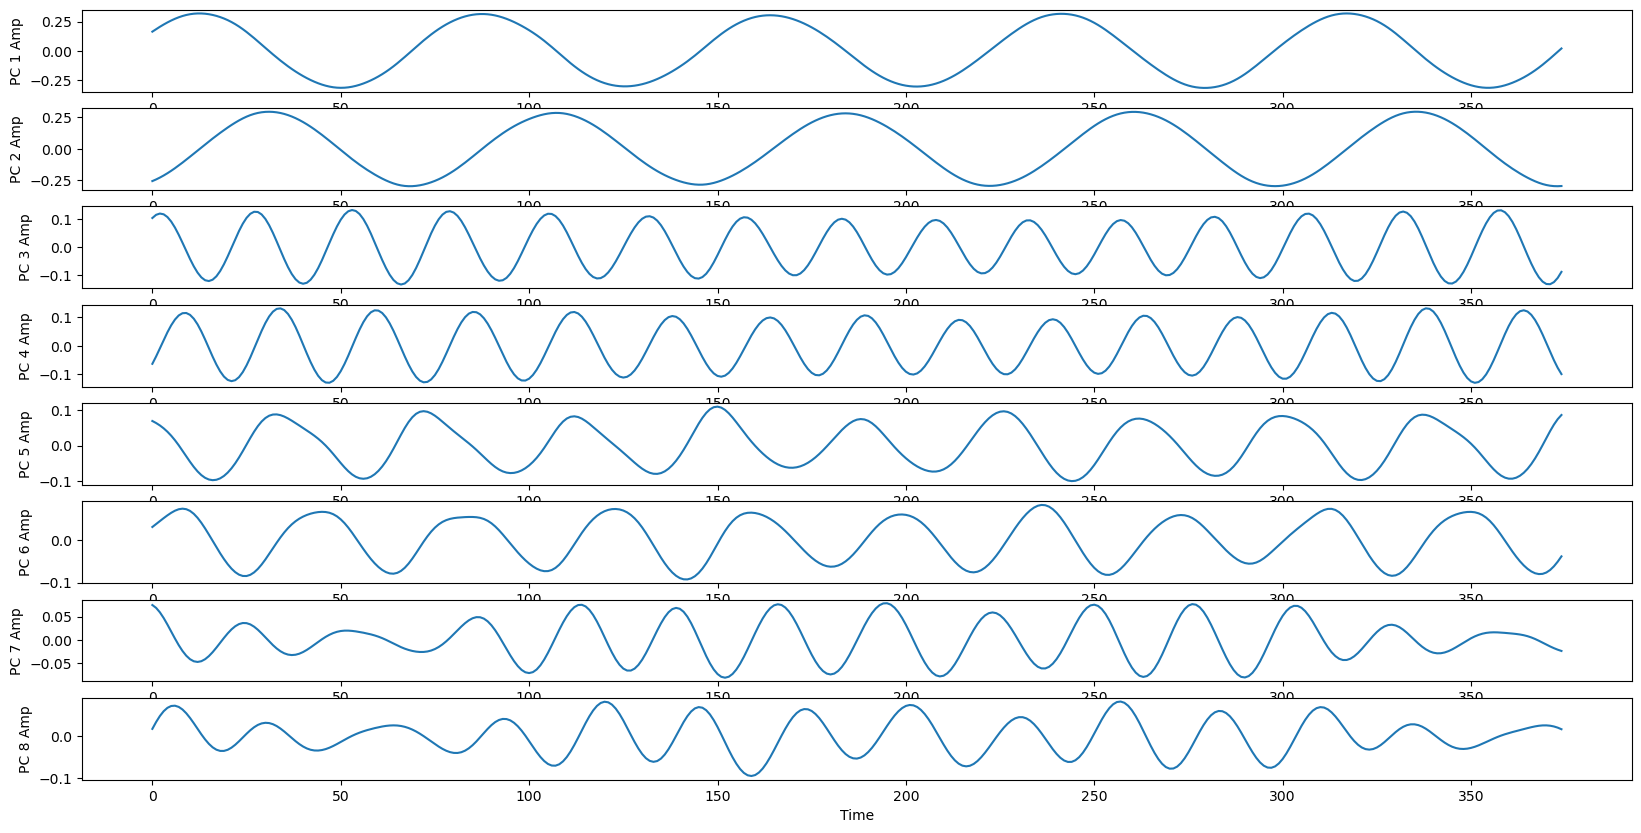

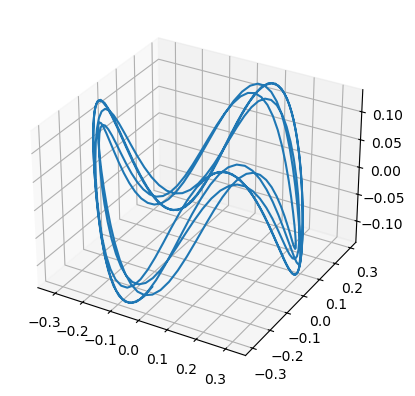

In [8]:
principal_components = np.reshape(
    pca.components_, (pca.components_.shape[0], vort_field.shape[1], vort_field.shape[2])
)


## Plot the principal components
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

## Plot the movie projected onto the principal components
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(X_reduced[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

## Plot the time series against each other
plt.figure()
ax = plt.axes(projection='3d')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2])

## Finding the Grassberber-Procaccia dimension

+ Beyond looking at the principal components, we can also use the Grassberber-Procaccia dimension to find the low-dimensional dynamics. We will use the implementation from the [dysts](https://github.com/williamgilpin/dysts) package.

In [207]:
### pip install --upgrade dysts
# https://github.com/GilpinLab/dysts/blob/3ac6f89372da0f5e1335d65fb6db8c967cccede4/dysts/analysis.py#L218

## If this fails, install scikit-learn
from dysts.analysis import twonn_dim
XX = np.random.randn(1000, 30)
print(twonn_dim(XX))

## If this fails, install hnswlib and run the approximate calculation
print(twonn_dim(XX, approximate=True))

np.float32(2.0980003)

In [20]:
XX = np.random.randn(1000, 30)
# print(gp_dim(XX))
# print(gp_dim_approximate(XX))
print(twonn_dim(XX))
print(twonn_dim(XX, approximate=True))
print(gp_dim(XX))
print(gp_dim_approximate(XX))


22.3920043541539
22.297937
3.4500087341878736
3.899


In [117]:
all_gpd = list()
all_gpd2 = list()
all_gpd_approx = list()
nvals = np.arange(5, 20, 1)
for d in nvals:
    print(d, flush=True)
    XX  = np.random.randn(4000, d)
    # all_gpd.append(gp_dim(XX))
    # all_gpd2.append(estimate_correlation_dimension(XX))
    all_gpd_approx.append(gp_dim_approximate(XX))
all_gpd = np.array(all_gpd)
# all_gpd2 = np.array(all_gpd2)
all_gpd_approx = np.array(all_gpd_approx)

plt.figure(figsize=(5, 5))
plt.plot(all_gpd, all_gpd_approx, 'o')
plt.plot(all_gpd, all_gpd, '--', color='red')
# plt.plot(all_gpd, all_gpd2, 'o')


plt.figure(figsize=(5, 5))
plt.plot(nvals, all_gpd_approx, '.')
plt.plot(nvals, all_gpd, 'o')
plt.plot(nvals, nvals, '--', color='black')
# plt.plot(nvals, all_gpd2, 'o')
print(np.polyfit(all_gpd, all_gpd_approx, 1))
print(np.polyfit(nvals, all_gpd, 1))
print(np.polyfit(nvals, all_gpd_approx, 1))



5


KeyboardInterrupt: 

In [ ]:
X  = np.random.randn(10000, 10000)
%timeit gp_dim(X)
%timeit gp_dim_approximate(X)


We observe two desirable properties of the correlation dimension: the result is independent of our total number of measurement coordinates, and the result agrees with the dropoff we observed in PCA

## Try next: repeat the analysis above, but change Re=300 in the first cell to a higher Reynolds number. As the system becomes more turbulent, the dynamics become more chaotic. You will see that the dimensionality of the dynamics will appear to increase